# Comprehensive Guide on SARSA Reinforcement Learning Algorithm in Python

## Introduction

Reinforcement Learning (RL) is a powerful machine learning paradigm. In RL, a software, usually called an agent, learns to interact with environments to solve complex problems through trial and error, all without human intervention. Among RL algorithms, SARSA stands out for its efficient on-policy nature. 

SARSA stands for State-Action-Reward-State-Action, representing a cycle the agent follows to solve problems. This cycle allows the agent to learn from its past mistakes and occasionally venture out to try new things. This behavior makes the algorithm particularly effective in specific problem types (discussed more later) and differentiates it from off-policy algorithms like Q-learning. 

In this tutorial, you will gain an intuition into how SARSA works and how you can implement it in Python. To make your understanding concrete, we will use a classic Taxi Ride problem throughout. We will also discuss SARSA's advantages, limitations and its real-world applications. 

## What is SARSA? The Short Answer

SARSA, short for State-Action-Reward-State-Action describes a sequence of events in a learning process. It is an effective method for RL computer programs (agents) to make good decisions in various scenarios. 

The main idea behind SARSA is trial and error. The agent takes an action in a situation, observes the result and adjusts its strategy based on the outcome (good or bad). This process is repeated many times, leading to improvements in agent's decisions over time. 

What makes SARSA special among RL algorithms is that SARSA learns from actual choices made by the agent, including when it is trying new things. This approach is particularly useful when the learning journey is just as important as the final result. 

It is like a robot learning to ride a bike by actually riding it, falls and all, instead of finding the shortest path from A to B by using protective training wheels. 

## Explaining the Taxi-V3 Environment

Throughout the tutorial we will use the Taxi-v3 environment, which is a classic reinforcement learning problem provided by the Gymnasium library. It simulates a taxi driver navigating a 5x5 grid world to pick up and drop off passengers. 

To load the environment, we use the `.make()` method of Gymnasium with an `rgb_array` render mode (to visualize the environment later):

In [61]:
import gymnasium as gym

env = gym.make('Taxi-v3', render_mode='rgb_array')

The environment is a 5x5 grid with 4 designated locations: Red (R), Green (G), Yellow (Y), and Blue (B). The taxi starts at a random square and must pick up a passenger at one of the colored locations and drop them off at another. The taxi can move North, South, East, or West, and can also attempt to pick up or drop off a passenger.

Here is how we can visualize the initial state of the environment with Matplotlib:

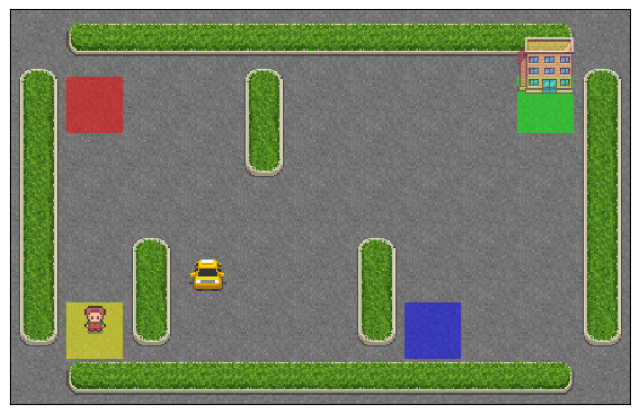

In [62]:
import matplotlib.pyplot as plt

# Reset the environment to get an initial state
initial_state, _ = env.reset()

# Render the initial state
img = env.render()

# Create a figure and display the environment
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([]);

First, we reset the environment to get an initial state. Then, we display this initial state with the `render` function, receiving a Numpy image array. Matplotlib's `imshow()` function takes this array and produces a clean visualization without axis ticks. 

Take a moment to understand the layout of the Taxi-v3 grid world, noting the taxi's position, passenger locations, and the destination. 

The agent (the taxi) receives +20 points for successfully dropping off a passenger. Illegal pick-up or drop-off results in -10 reward. All the while, every time step produces -1 reward to encourage the taxi to complete the task quickly.

A single episode of the Taxi-v3 environment terminates in the case of a successful drop-off or when the maximum number of time steps (usually 200) is reached. 

In [64]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print(n_states)
print(n_actions)

500
6


There are 500 states in the environment's state space. Each state is represented by:
- Taxi row (0-4)
- Taxi column (0-4)
- Passenger location (0-3 for R, G, Y, B, or 4 for inside the taxi)
- Destination location (0-3 for R, G, Y, B)

The action codes are:

- 0: Move South
- 1: Move North
- 2: Move East
- 3: Move West
- 4: Pickup passenger
- 5: Drop off passenger

The goal is for the agent to learn an optimal policy to maximize its total reward by efficiently picking up and dropping off passengers.

## SARSA Interaction Loop

Episode 0, Avg Reward: -605.00, Avg Length: 200.00
Episode 1000, Avg Reward: -123.83, Avg Length: 91.20
Episode 2000, Avg Reward: -4.30, Avg Length: 19.38
Episode 3000, Avg Reward: 1.91, Avg Length: 15.09
Episode 4000, Avg Reward: 2.45, Avg Length: 14.78
Episode 5000, Avg Reward: 2.41, Avg Length: 14.71
Episode 6000, Avg Reward: 2.39, Avg Length: 14.87
Episode 7000, Avg Reward: 2.60, Avg Length: 14.67
Episode 8000, Avg Reward: 2.72, Avg Length: 14.64
Episode 9000, Avg Reward: 2.51, Avg Length: 14.64
Episode 10000, Avg Reward: 2.32, Avg Length: 14.69
Episode 11000, Avg Reward: 2.23, Avg Length: 14.88
Episode 12000, Avg Reward: 2.38, Avg Length: 14.50
Episode 13000, Avg Reward: 1.83, Avg Length: 14.98
Episode 14000, Avg Reward: 2.18, Avg Length: 14.88
Episode 15000, Avg Reward: 2.41, Avg Length: 14.92
Episode 16000, Avg Reward: 2.45, Avg Length: 14.75
Episode 17000, Avg Reward: 2.32, Avg Length: 14.68
Episode 18000, Avg Reward: 2.66, Avg Length: 14.65
Episode 19000, Avg Reward: 2.04, Avg

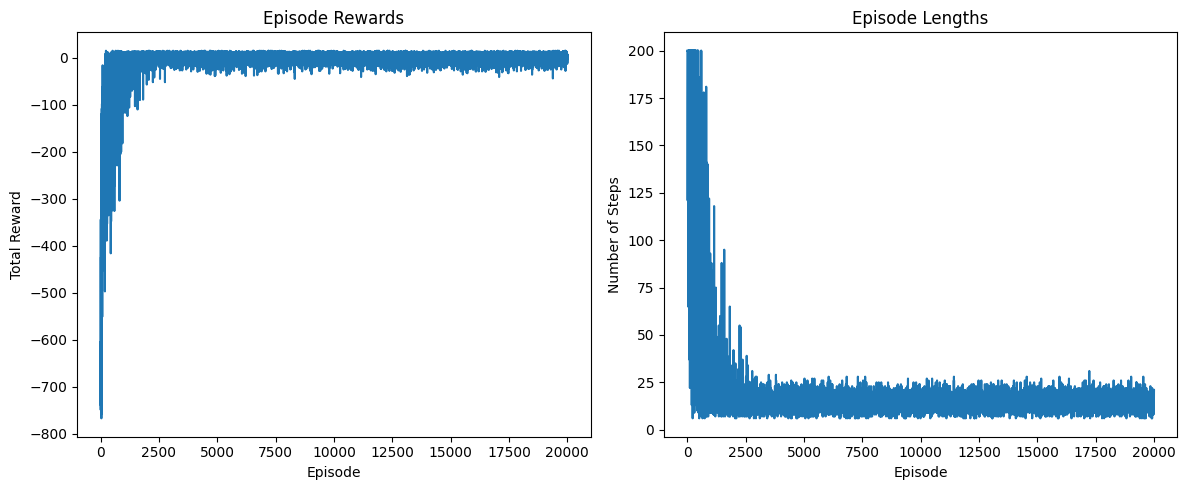

In [52]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Create the Taxi environment
env = gym.make("Taxi-v3")

# Initialize Q-table
n_states = env.observation_space.n
n_actions = env.action_space.n
Q = np.zeros((n_states, n_actions))

# SARSA parameters
alpha = 0.1
gamma = 0.99
epsilon = 0.1
n_episodes = 20000

# Lists to store performance metrics
episode_rewards = []
episode_lengths = []

def epsilon_greedy(state, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

# SARSA training loop
for episode in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state, epsilon)
    done = False
    total_reward = 0
    steps = 0

    while not done:
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_action = epsilon_greedy(next_state, epsilon)

        Q[state, action] += alpha * (
            reward + gamma * Q[next_state, next_action] - Q[state, action]
        )

        state = next_state
        action = next_action
        total_reward += reward
        steps += 1

    episode_rewards.append(total_reward)
    episode_lengths.append(steps)

    if episode % 1000 == 0:
        avg_reward = np.mean(episode_rewards[-1000:])
        avg_length = np.mean(episode_lengths[-1000:])
        print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Avg Length: {avg_length:.2f}")

# Plot the learning curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')

plt.tight_layout()
plt.show()

Interpretation of the Learning Curves

The plots above show the learning progress of the SARSA algorithm in the Taxi-v3 environment.

Episode Rewards:
The left plot displays the total reward obtained in each episode. We can observe that:
- Initially, the rewards are low and highly variable, indicating that the agent is exploring and learning.
- Over time, there's an upward trend in the rewards, suggesting that the agent is improving its policy.
- Towards the end, the rewards seem to stabilize at a higher level, indicating that the agent has learned a reasonably good policy.

Episode Lengths:
The right plot shows the number of steps taken in each episode. We can see that:
- At the beginning, episodes tend to be longer, as the agent is taking suboptimal actions.
- As learning progresses, there's a general downward trend in episode length.
- The episode lengths eventually stabilize, suggesting that the agent has learned to complete the task more efficiently.

Overall, these plots demonstrate that the SARSA algorithm is successfully learning to navigate the Taxi environment, improving both its reward accumulation and task efficiency over time.

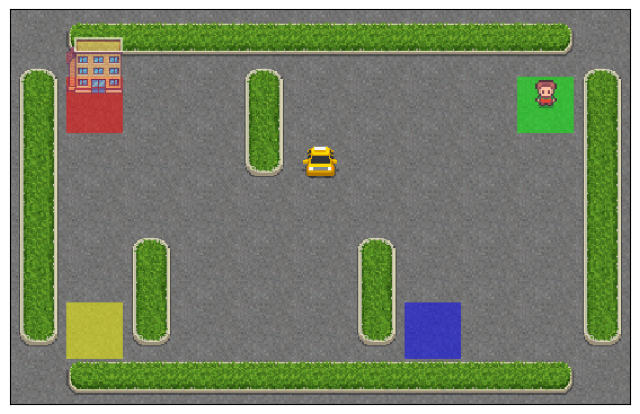

In [55]:
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the Taxi environment
env = gym.make('Taxi-v3', render_mode='rgb_array')

# Reset the environment to get an initial state
initial_state, _ = env.reset()

# Render the initial state
img = env.render()

# Create a figure and display the environment
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([]);

## Prerequisites and Fundamentals

To make sure we are all on the same page, we will refresh some reinforcement learning fundamentals and key ideas such as Q-learning before we tackle SARSA headlong.

### Reinforcement Learning Basics
- Agents, environments, states, and actions
- Rewards and return

### Markov Decision Processes (MDPs)
- Markov property
- State transition probabilities
- Reward function


### Q-learning Fundamentals
- Action-value function (Q-function)
- Bellman equation


### Exploration vs. Exploitation
- Epsilon-greedy policy


### On-policy vs. Off-policy Learning


### SARSA vs Q-learning: Key Differences



## SARSA Algorithm Explained
- Step-by-step breakdown of the algorithm
- SARSA update rule
- Differences between SARSA and Q-learning (expanded)



## Implementing SARSA for Cliff Walking

### 1. Setting up the Cliff Walking environment


### 2. Initializing the Q-table


### 3. Implementing the epsilon-greedy policy


### 4. SARSA update function


### 5. Hyperparameter selection
   - Learning rate
   - Discount factor
   - Epsilon (exploration rate)


### 6. Training loop


### 7. Visualizing the learned policy


### 8. Common Challenges and Solutions



## Experiments and Results
- Training the agent
- Analyzing the learned policy
- Comparing SARSA's performance with Q-learning
- Interpreting results and debugging tips



## Conclusion
- Recap of SARSA algorithm
- Advantages and limitations
- Real-world applications of SARSA
- Further reading and resources


In this article, we explored the SARSA algorithm, a fundamental reinforcement learning technique. We covered its core principles, implementation, and applications.

We introduced the algorithm, its mathematical foundations, and implemented it step-by-step. We discussed hyperparameter selection, training, policy visualization, and common challenges.

Through experiments, we compared SARSA's performance with Q-learning, highlighting its on-policy nature and advantages in certain scenarios.

SARSA excels in environments where agent actions directly influence subsequent states, but may be less sample-efficient than some off-policy algorithms.

Real-world applications include robotics, game playing, and resource management. Understanding SARSA provides a foundation for more complex reinforcement learning problems.